In [30]:
import torch
from torch import nn 
from torch import optim 
from torch.optim import SGD
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import numpy as np 
import matplotlib.pyplot as plt

In [31]:
X, y = make_classification(n_samples=1000, n_features=4,  n_classes=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Giving 4 dimensions to the data
# Scaling using Standard Scaling 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_t = torch.tensor(X_train, dtype=torch.float32) 
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [32]:
class LogisticRegressionModel(nn.Module): 
    def __init__(self, in_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(in_dim, 1)
    def forward(self, x): 
        return torch.sigmoid(self.linear(x))

model = LogisticRegressionModel(in_dim =X_train.shape[1])
model

LogisticRegressionModel(
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

In [33]:
l = nn.BCELoss()
optim = SGD(model.parameters())
epochs = 10000 
loss_hist = []
for epoch in range(epochs): 
    model.train()
    optim.zero_grad()
    outputs = model(X_train_t)
    loss = l(outputs, y_train_t) 
    loss.backward()
    optim.step()

    loss_hist.append(loss.item())
    if epoch%100 == 0: 
        print("Epoch number: ", epoch, " BCELoss: ", loss.item()) 

model.eval()
with torch.no_grad(): 
    y_pred_probs = model(X_test_t) 
    y_pred_labels = (y_pred_probs >= 0.5).float()
    acc = accuracy_score(y_test_t.numpy(), y_pred_labels.numpy())
    print(f"\nTest Accuracy: {acc:.4f}")

Epoch number:  0  BCELoss:  0.6217902898788452
Epoch number:  100  BCELoss:  0.6098829507827759
Epoch number:  200  BCELoss:  0.598829984664917
Epoch number:  300  BCELoss:  0.5885468125343323
Epoch number:  400  BCELoss:  0.5789592862129211
Epoch number:  500  BCELoss:  0.5700021982192993
Epoch number:  600  BCELoss:  0.561618447303772
Epoch number:  700  BCELoss:  0.5537570118904114
Epoch number:  800  BCELoss:  0.5463730692863464
Epoch number:  900  BCELoss:  0.5394267439842224
Epoch number:  1000  BCELoss:  0.532882034778595
Epoch number:  1100  BCELoss:  0.5267070531845093
Epoch number:  1200  BCELoss:  0.5208731293678284
Epoch number:  1300  BCELoss:  0.5153543949127197
Epoch number:  1400  BCELoss:  0.5101274251937866
Epoch number:  1500  BCELoss:  0.5051711201667786
Epoch number:  1600  BCELoss:  0.5004664063453674
Epoch number:  1700  BCELoss:  0.49599578976631165
Epoch number:  1800  BCELoss:  0.49174344539642334
Epoch number:  1900  BCELoss:  0.4876948893070221
Epoch number:

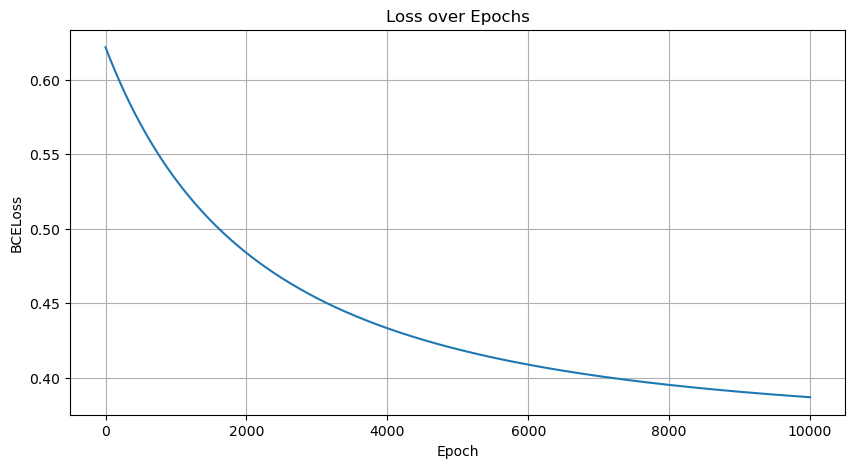

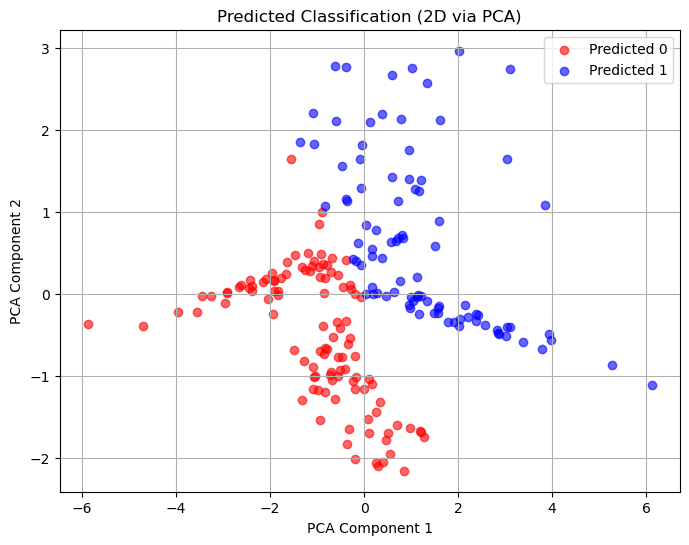

In [34]:
#Not producing a boundary as it is a 4D model
from sklearn.decomposition import PCA
plt.figure(figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("BCELoss")
plt.grid(True)
plt.show()

# Plotting classification points (PCA to reduce to 2D)
pca = PCA(n_components=2)
X_test_2D = pca.fit_transform(X_test)
y_pred_labels_np = y_pred_labels.numpy().flatten()


plt.figure(figsize=(8, 6))
plt.scatter(X_test_2D[y_pred_labels_np == 0, 0], X_test_2D[y_pred_labels_np == 0, 1], color='red', label='Predicted 0', alpha=0.6)
plt.scatter(X_test_2D[y_pred_labels_np == 1, 0], X_test_2D[y_pred_labels_np == 1, 1], color='blue', label='Predicted 1', alpha=0.6)
plt.title("Predicted Classification (2D via PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train) # X_train and y_train is the scaled data from before
lr_pred = lr.predict(X_test) 

print("Test accuracy: ", accuracy_score(lr_pred, y_test))

Test accuracy:  0.885


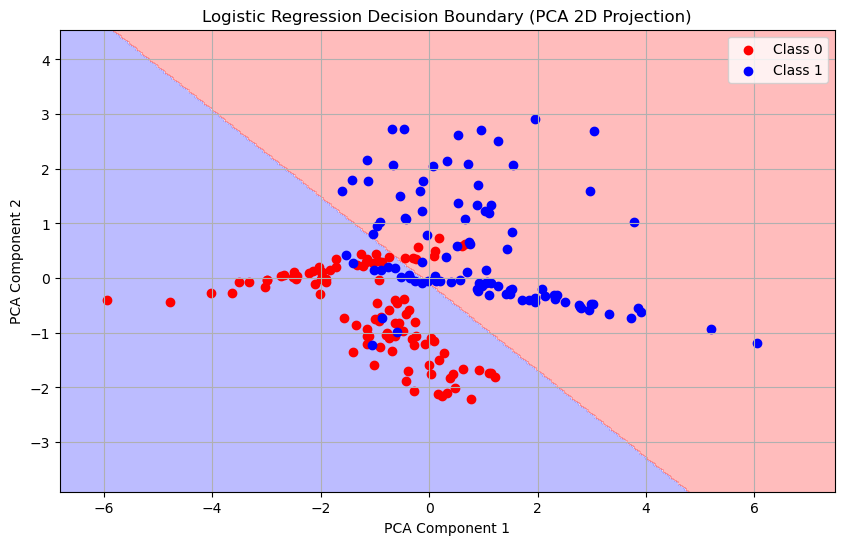

In [39]:
pca = PCA(n_components=2) 
X_train_pca = pca.fit_transform(X_train) 
X_test_pca = pca.transform(X_test)

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_original_space = pca.inverse_transform(grid)
Z = lr.predict(grid_original_space).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
plt.scatter(X_test_pca[y_test == 0][:, 0], X_test_pca[y_test == 0][:, 1], c='red', label='Class 0')
plt.scatter(X_test_pca[y_test == 1][:, 0], X_test_pca[y_test == 1][:, 1], c='blue', label='Class 1')
plt.title("Logistic Regression Decision Boundary (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()